In [1]:
from arcgis import GIS
from arcgis import features
import arcpy
import os

In [2]:
gis = GIS("https://aremirez.maps.arcgis.com/", "aremirezdev")

Enter password: ········


In [3]:
# valores del WFS del gobierno de Navarra
wfsUrl = 'https://inspire.navarra.es/services/coronavirus/ows'
wfsLayerName = 'Navarra_Coronavirus_ZBS_C'

# FileGDB local donde me exportaré los datos del WFS
localGDB = 'C:\\Temp\\Lodosa\\Navarra\\Navarra.gdb'
localFC = os.path.join(localGDB, wfsLayerName)

In [4]:
# Me aseguro de no contar previamente con esta FC en local. Podríamos salvar una FC por fecha de exportación como haremos más adealnte con las layers en ArcGIS Online
if arcpy.Exists(localFC):
    arcpy.Delete_management(localFC)
arcpy.WFSToFeatureClass_conversion(wfsUrl, wfsLayerName, localGDB, wfsLayerName)

<Result 'C:\\Temp\\Lodosa\\Navarra\\Navarra.gdb'>

In [5]:
# usamos el spatially enabled dataframe del API (basado en pandas) para leer una FC
fc = features.GeoAccessor.from_featureclass(localFC)
fc.head()

,OID,GmlID,COD_ZBS,ZBS,CASOS,TASA_1000h,FECHADATOS,SHAPE
0,1,Navarra_Coronavirus_ZBS_C.1,1,Altsasu/Alsasua,48,6.08,09-05-2020,"{'rings': [[[565792.2745000003, 4755523.604], ..."
1,2,Navarra_Coronavirus_ZBS_C.2,3,Irurtzun,29,4.40,09-05-2020,"{'rings': [[[582319.8996000001, 4770046.0591],..."
2,3,Navarra_Coronavirus_ZBS_C.3,4,Leitza,6,1.82,09-05-2020,"{'rings': [[[600355.1153999995, 4779566.558], ..."
3,4,Navarra_Coronavirus_ZBS_C.4,5,Lesaka,11,1.58,09-05-2020,"{'rings': [[[615659.0042000003, 4789568.3168],..."
4,5,Navarra_Coronavirus_ZBS_C.5,6,Elizondo,72,10.28,09-05-2020,"{'rings': [[[626495.9418000001, 4767876.4365],..."


In [6]:
# es importante conocer en qué momento hemos salvado estos datos así que lo reflejaremos en el nombre de la capa. Podríamos haber hecho esto mismo con las FC locales
import datetime as dt
def now_dt():
    return datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")

In [7]:
# guardamos en nuestra organización de ArcGIS Online los datos exportados
new_covid_item = fc.spatial.to_featurelayer(title=wfsLayerName + '_' + now_dt(),
                                                gis=gis,
                                                tags="Navarra, Covid")
new_covid_item

<Item title:"Navarra_Coronavirus_ZBS_C_2020_05_10-13_13_34" type:Feature Layer Collection owner:aremirezdev>

<Item title:"Zonas de salud básicas" type:Feature Layer Collection owner:aremirezdev>
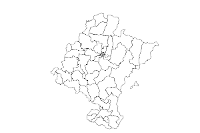

In [8]:
zonas_salud = gis.content.search('Zonas de salud')[0]
zonas_salud

In [9]:
from IPython.display import clear_output, display
import ipywidgets as widgets

In [18]:
# creamos el mapa con la capa cargada sin filtro
map = gis.map('Navarra')
map.basemap = 'gray-vector'
map.add_layer(zonas_salud)
map.add_layer(new_covid_item, {"renderer":"ClassedColorRenderer", "field_name": "TASA_1000h"})

# creamos el widget slider con un rango de contagios entre 0 y 20 por cada 1.000 habitantes
style = {'description_width': 'initial'}
slider = widgets.FloatSlider(
    value=0,
    min=0,
    max=20,
    step=1,
    description='Tasa de contagio por cada 1.000 habitantes:',
    style=style,
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    layout=widgets.Layout(width='50%', height='20px')
)
def on_change(change):
    map.remove_layers(layers=new_covid_item)
    map.add_layer(new_covid_item, {"renderer":"ClassedColorRenderer", "field_name": "TASA_1000h", "definition_expression":"TASA_1000h >" + str(change['new'])})
slider.observe(on_change, names='value')

# creamos el botón de imprimir para que nos genere un PNG en local
button = widgets.Button(
    description='Imprimir',
    button_style='success',
    tooltip='Imprimir'
)
def on_click(button_object):
    map.take_screenshot(file_path=r"C:\\Temp\\Lodosa\\Navarra\\map.png")
button.on_click(on_click)

# mostramos en una única celda mapa, slider y botón de impresión
display(map)
display(slider)
display(button)

MapView(layout=Layout(height='400px', width='100%'))

FloatSlider(value=0.0, continuous_update=False, description='Tasa de contagio por cada 1.000 habitantes:', lay…

Button(button_style='success', description='Imprimir', style=ButtonStyle(), tooltip='Imprimir')